# User Guide for ridgeline program

This notebook provides a framework for extracting maximum elevation values ('ridges') along either side of a predefined thalweg (obtained from QGIS).

Ridgelines obtained from this program will be plotted over CTD transects of temperature and salinity to see how bathymetric patterns may shape local hydrography. The development of this program and examples included herein used bathymetric data from glacier fjords and the continental shelf in Melville Bay, northwest Greenland.

In [8]:
from datetime import date
print("Document updated: ", date.today())

Document updated:  2022-09-30


## Overview of program

SUMMARY OF HOW THE PROGRAM WORKS WITH FIGURE TO VISUALIZE THE ELEMENTS

****

## 1. Required data files:

1) Bathymetric data (netCDF format) are sourced from BedMachine V4 and can be downloaded [here](https://sites.ps.uci.edu/morlighem/dataproducts/bedmachine-greenland/).
2) Thalweg csv file with the following columns:
    - `distance` (in meters from glacier front to outer edge of continental shelf)
    - `x` (EPSG 3413 coordinate)
    - `y` (EPSG 3413 coordinate)
    - `Bed_meters` (*OPTIONAL* - not required for this program to extract ridgelines but these are used in final CTD transect plots)
3) Reference line csv file with the following columns:
    - `distance` (straight line in meters running parallel to thalweg)
    - `x` (EPSG 3413 coordinate)
    - `y` (EPSG 3413 coordinate)
    
*Instructions for obtaining (2) and (3) are included below*

****

### 1a. Instructions for creating and exporting csv with thalweg data using QGIS

Below are instructions for hand-drawing a thalweg in QGIS where BedMachine bathymetry and CTD profile coordinates are imported and plotted. CTD locations are used to identify transects of interest, along which a thalweg will be drawn and neighboring ridgelines (channel) will be extracted.

To draw a thalweg:
1) Select button in upper left for "New Shapefile Layer." For filename, select the three dots on the right to navigate to where you want the shapefile to be saved and your desired filname. The geometry type is LineString. Select appropriate coordinate system (here, Polar stereographic north EPSG 3413). Press OK.
2) In the Layers pane on the left, select the new shapefile layer. Then press the pencil icon at the top to begin editing this layer. Click "add line feature" (two buttons to the right of the pencil).
3) Click points on the map to create the thalweg line. Right click to finish. Save and exit editing mode. (Optional: smooth line using "smooth" tool. Setting the offset to 0.5 works well)
4) Create equidistant points along the line by opening the "Points along geometry" tool in the Processing Toolbox pane on the right. Input layer is the your hand-drawn (or smoothed) line. Choose the resolution you want for distance (here, 50 meters between points was used). Note: You do not need to save the new "interpolated points" scratch layer as a shapefile layer.
5) Right click the interpolated points layer and select "open attribute table." Click the pencil button in upper left to enter edit mode. Click the "delete fields" button to delete unneeded columns "ID" and "angle."
6) Still in the attribute table, press the 'open field calculator' button and add `$x` and `$y` (separately) for x and y coordinates of each point. When you add $x be sure to click "create virtual field" and enter output field name as "x" or "y." Output field type should be Decimal number (double). Close attribute table.
7) OPTIONAL: To extract bathymetric values (from BedMachine data) along the thalweg, search for "sample raster values" tool in the Processing Toolbox pane on the right and open it. The input layer is your interpolated points layer and the raster layer is the bedmachine bathymetry layer. Type "Bed_meters" in the output column name prefix (i.e., column header). Click run. Save the new "sampled" scratch layer as a shapefile layer.
8) Right click this new sampled layer and press "export" > "save vector layer as...". The format should be CSV and make sure the coordinate system is EPSG 3413. Deselect "add saved file to map." Press ok. Use this csv file for ridgeline program.

### 1b. Instructions for creating and exporting csv for reference line using QGIS

In order to extract ridgelines on either side of the thalweg line, a reference line is used. Begin using a straight line and see if you obtain a satisfactory result. If not, you may try a reference line that contains some bent angles.

To create the reference line csv file:
1. Repeat steps (1) through (6) from section 1a above, except you will create a straight line instead of a winding thalweg. The reference line will run parallel to the thalweg you drew.
2. You do not need to extract bathymetry values for this line. One you have the shapefile layer saved, right click the layer and press "export" > "save vector layer as...". The format should be CSV and make sure the coordinate system is EPSG 3413. Deselect "add saved file to map." Press ok. Use this csv file for ridgeline program in addition to the csv file for the thalweg.

**Below is a screenshot from QGIS showing an example hand-drawn thalweg (black) and reference line (red) running from Sverdrup glacier to the edge of the continental shelf (in the Melville Bay basin).**

The thin lines on either side of the thalweg are hand-drawn ridgelines used to compare to the program's ridgeline output (see validation section below)

<img src="../QGIS_example_thalweg_and_ref.JPG" width=500>

****

## 2. Import python libraries

In [23]:
import numpy as np
import pandas as pd

from pathlib import Path
import xarray as xr

import matplotlib.pyplot as plt
# from matplotlib import cm
# import matplotlib as mpl
# import matplotlib.colors as mcolors

import netCDF4 as nc4

# from matplotlib.gridspec import GridSpec
# import cmocean
# import rioxarray
from pygc import great_circle
from pygc import great_distance
from pyproj import Proj, transform, Transformer, CRS
# import pyresample
# import cartopy
# import cartopy.mpl.geoaxes
# import cartopy.crs as ccrs
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import matplotlib.patches as mpatches
# from matplotlib.colors import ListedColormap
# from scipy.signal import argrelextrema
# from scipy.signal import savgol_filter

## 3. Extract canyon ridgelines along channel

### 3a. Load bathymetry data and csv files for thalweg and reference line

<div class="alert alert-success">Here, edit directories with paths for where your files are stored.</div>

Load BedMachine data for Melville Bay region. 

In [18]:
# import bathymetry data
bedmachine_ds = xr.open_dataset('../../data/bathymetry/BedMachine_v4_regions/bedmachineV4_moorings_region.nc')

In [19]:
# create mask for only bathymetry values less than zero (below surface) - set values > 0 to zero.
bed_masked_ds = bedmachine_ds.bed.where(bedmachine_ds.bed<0, 0)

Load csv files for thalweg and reference line

In [24]:
# function that reprojects polar stereographic to lat/lon coordinates
# lat/lon coordinates are needed in the functions below
def transform_projection_to_EPSG4326(transect_points_df):
    transformer = Transformer.from_crs('EPSG:3413','EPSG:4326')
    lat, lon = transformer.transform(transect_points_df.x,transect_points_df.y)
    return lat,lon

In [27]:
# import all transect data
sverdrup_transect_points_df = pd.read_csv('sverdrup_thalweg.csv')
sverdrup_ref_points_df      = pd.read_csv('sverdrup_reference_line.csv')

# transform x,y coords to lat,lon
sver_lat, sver_lon                 = transform_projection_to_EPSG4326(sverdrup_transect_points_df)
sverdrup_ref_lat, sverdrup_ref_lon = transform_projection_to_EPSG4326(sverdrup_ref_points_df)

### 3b. Load functions

*Summary of functions:*

`nearest_line_bedmachine()`

`get_search_line_and_peak()`

`get_ridge_points()` - Function that creates final DataArray for the smoothed ridgeline using indices of maximum elevation (along search lines) that were corrected for outliers

`define_canyon_ridgeline()`


In [4]:
def nearest_line_bedmachine(lats_swath, lons_swath, data_grid, grid_bedmachine):
    """
    Function that uses the lat/lon points of a search line get indices of the closest lat/lon points in the Bedmachine dataset.
    Returns 'index_array_2d' which provides indices in bathymetry data that most closely match points along the search line.
    """
    
    # find nearest neighbor lat/lon values from bedmachine data using normal line lat/lon swaths
    swath = pyresample.geometry.SwathDefinition(lons=lons_swath, lats=lats_swath)
    
    # Determine nearest (w.r.t. great circle distance) neighbour in the grid.
    _, _, index_array, distance_array = pyresample.kd_tree.get_neighbour_info(
        source_geo_def=grid_bedmachine, target_geo_def=swath, radius_of_influence=250,neighbours=1)
    
    # get_neighbour_info() returns indices in the flattened lat/lon grid. Compute the 2D grid indices:
    index_array_2d = np.unravel_index(index_array, grid_bedmachine.shape)
    
    return index_array_2d

In [5]:
def get_search_line_and_peak(lon_thalweg_slice, lat_thalweg_slice, line_points_array, azimuth, distance, data_grid,\
                             lat_grid_bedmachine, lon_grid_bedmachine, grid_bedmachine):
    
    """
    Function that creates a search line that extends from the thalweg on either side (north side='plus'; south side='minus')
    Along each search line, the point of maximum elevation (i.e., the ridge) is selected.
    Returns DataArray with search line's lat/lon coordinates, elevation, and peak index (=point along search line selected as ridge).
    
    Note: This function utilizes nearest_line_bedmachine() function defined above.
    """
    
    # get line (with defined length and # points equal to line_points_array) at specified angle (=azimuth)
    line_swath = great_circle(distance=line_points_array, azimuth=azimuth, latitude=lat_thalweg_slice, longitude=lon_thalweg_slice)
    lons_swath = line_swath['longitude']
    lats_swath = line_swath['latitude']
    
    # function that uses lat/lon from search line (=swath) to get closest lat/lon point and bathymetry value from Bedmachine dataset
    index_array_2d = nearest_line_bedmachine(lats_swath, lons_swath, data_grid, grid_bedmachine)
    
    # get search line lat/lons
    lat_line = lat_grid_bedmachine[index_array_2d][:] # lat points for line along which I select the max elevation
    lon_line = lon_grid_bedmachine[index_array_2d][:] # lon points for line along which I select the max elevation
    # get bathymetry values along search line
    bathy_line = np.array([data_grid[index_array_2d]])
    
    # create array of line indices
    line_indices = np.arange(len(line_points_array))
    
    ## FIND INDEX OF PEAK ELEVATION ##
    # if there are multiple maximums and the difference is greater than X meters, then select first max
    line_tmp = data_grid[index_array_2d] # pull out search line
    # identify local max and mins
    local_max = argrelextrema(line_tmp, np.greater)[0]
    local_min = argrelextrema(line_tmp, np.less)[0]
    # get difference in elevation along line
    diff_array = np.diff(line_tmp)
    
    # if 0 (surface) is the max, take the first instance of 0
    if line_tmp.max() == 0:
        index_peak = np.argmax(line_tmp)
    elif len(local_max) == 0:
        index_peak = int(len(line_tmp)/2)
    ## if there is only 1 peak, take maximum
    elif len(local_max) == 1:
        index_peak = local_max[0]
    ## Select the local max elevation if:
    # 1) if there is more than one peak (local maxima) and
    # 2) the difference in elevation between the local max and min is greater than 50m (=less than -50m)
    elif len(local_max) > 1:
        # first calculate the difference in elevation between all local mins/maxs
        diff_elevation = []
        for i in range(len(local_max)-1):
            diff_elevation.append(diff_array[(local_max[i]):local_min[i]].sum())
    
        # if the last point is a minimum, it is not considered a local min, so we need to add the last elevation change here
        if len(local_max)!=len(local_min):
            diff_elevation.append(diff_array[(local_max[-1]):].sum())
        
        # if any elevation change between local mins/maxes exceeds our threshold, select that maximum
        if np.any(np.array(diff_elevation) < -100):
            index_local_max = np.where(np.array(diff_elevation) < -100)[0][0] # get index of the first local max that exceeds our threshold
            index_peak = local_max[index_local_max]
        # if none exceed threshold and the last point is NOT the max value, then take maximum
        elif np.argmax(line_tmp) != (len(line_tmp)-1):
            index_peak = np.argmax(line_tmp)
        # if none exceed threshold and the max elevation is the last point on the line, select a midpoint
        else: index_peak = int(len(line_tmp)/2)

    line_da = xr.DataArray(data=bathy_line, dims=['distance','line_indices'],
                           coords={'distance':[distance],'line_indices':line_indices,
                                   'lon':(['line_indices'],lon_line), 'lat':(['line_indices'],lat_line), 'index_peak':(['distance'],[index_peak])})
    
    return line_da

In [6]:
def get_ridge_points(lines_ds):
    """
    Use 'peak_index' coordinate in 'lines_ds' to extract bathymetry and lat/lon coordinates for the ridgeline.
    Returns DataArray of final ridgeline.
    """
    bathy_peak = []
    for i in range(len(lines_ds.distance.values)):
        bathy_peak.append(lines_ds.values[i][lines_ds.index_peak.data[i]])
        
    lat_peak = []
    for i in range(len(lines_ds.distance.values)):
        lat_peak.append(lines_ds.lat.values[i][lines_ds.index_peak.data[i]])
    
    lon_peak = []
    for i in range(len(lines_ds.distance.values)):
        lon_peak.append(lines_ds.lon.values[i][lines_ds.index_peak.data[i]])
        
    # build DataArray for final ridgeline
    ridgeline_da = xr.DataArray(data=bathy_peak, dims=['distance'],
                                coords={'distance':lines_ds.distance.values,'index_peak':(['distance'], lines_ds.index_peak.data),
                                        'lat':(['distance'], lat_peak), 'lon':(['distance'], lon_peak)})
    return ridgeline_da

In [19]:
def define_canyon_ridgeline(bed_masked_ds, lon_thalweg_array, lat_thalweg_array, lon_ref_array, lat_ref_array,\
                            transect_points_df, fjord='Rink', slice_by=30, normal_line_length=5000):
    """
    Function that:
    1) searches along lines extending from the thalweg to reference line
    2) identifies the maximum elevation (i.e., ridge) using specified criteria
    3) smoothes ridgelines by identifying outlier points and using neighboring points to interpolate correct ridge position
    4) saves six netCDFs:
        - ridgeline_minus_da        = DataArray with selected maximum elevation points along southern ridge relative to thalweg (= 'minus') without smoothing
        - ridgeline_plus_da         = DataArray with selected maximum elevation points along northern ridge relative to thalweg (= 'plus') without smoothing
        - ridgeline_minus_smooth_da = DataArray with selected maximum elevation points along southern ridge with smoothing
        - ridgeline_plus_smooth_da  = DataArray with selected maximum elevation points along northern ridge with smoothing
        - lines_ds_minus            = Dataset with search lines for 'minus' ridge (south of thalweg) used to extract max elevation points
        - lines_ds_plus             = Dataset with search lines for 'plus' ridge (north of thalweg) used to extract max elevation points
    5) Returns variables of the six arrays/datsets defined in (4)
    Note: This function utilizes get_search_line_and_peak() and get_ridge_points() functions defined above.
    """
    
    # subset the thalweg and reference line points because we don't need to sample at a dense resolution of every 50 m
    lon_thalweg_slice = np.append(lon_thalweg_array[0::slice_by],lon_thalweg_array[-1]) # selects every `slice_by` element + last point
    lat_thalweg_slice = np.append(lat_thalweg_array[0::slice_by],lat_thalweg_array[-1]) # selects every `slice_by` element + last point
    lon_ref_slice = np.append(lon_ref_array[0::5],lon_ref_array[-1])
    lat_ref_slice = np.append(lat_ref_array[0::5],lat_ref_array[-1])
    
    # how many points to sample bathymetry along search line
    line_points_array = np.arange(1000, normal_line_length+200, 200)

    # USING REFERENCE LINE --------------------------------------------
    # find matching points on line running parallel to thalweg and thalweg points (= two points with minimum distance between them) and obtain angle
    angle_to_ref_minus = []
    angle_to_ref_plus = []
    for i in range(len(lon_thalweg_slice)):
        tmp = great_distance(start_latitude=[lat_thalweg_slice[i]] * len(lat_ref_slice), start_longitude=[lon_thalweg_slice[i]] * len(lon_ref_slice), 
                             end_latitude=lat_ref_slice, end_longitude=lon_ref_slice)
        
        distance = tmp['distance'].tolist()
        azimuth = tmp['azimuth'].tolist()
        azimuth_reverse = tmp['reverse_azimuth'].tolist()
        
        matching_point_index = np.argmin(distance) # index of point along ref line that corresponds to closest point on thalweg
        angle_to_ref_minus.append(azimuth[matching_point_index]) # angle between thalweg point and matching point on ref line
        angle_to_ref_plus.append(azimuth_reverse[matching_point_index])

    # Define lat-lon grid
    lon_grid_bedmachine = bed_masked_ds.lon.values
    lat_grid_bedmachine = bed_masked_ds.lat.values
    grid_bedmachine = pyresample.geometry.GridDefinition(lats=lat_grid_bedmachine, lons=lon_grid_bedmachine)
    # Data on the grid
    data_grid = bed_masked_ds.values
    
    index_peak_minus = []
    lats_minus = []
    lons_minus = []
    bathy_minus = []
    index_peak_plus = []
    lats_plus = []
    lons_plus = []
    bathy_plus = []
    
    lon_thalweg = lon_thalweg_slice.copy()[:-1]
    lat_thalweg = lat_thalweg_slice.copy()[:-1]
    
    search_lines_lat_minus = []
    search_lines_lon_minus = []
    search_lines_lat_plus = []
    search_lines_lon_plus = []
    
    # create dataset with search lines and associated bathymetry values along those lines for each point along the thalweg
    distance_transect = transect_points_df.distance.to_numpy()  
    distance_slice = distance_transect[0::slice_by]
    
    for i in range(len(lon_thalweg)):
        # returns peak bathymetry value along line and corresponding lat/lon coordinates
        line_da_minus = get_search_line_and_peak(lon_thalweg[i], lat_thalweg[i], line_points_array, angle_to_ref_minus[i], distance_slice[i],
                                                 data_grid, lat_grid_bedmachine, lon_grid_bedmachine, grid_bedmachine)
        line_da_plus = get_search_line_and_peak(lon_thalweg[i], lat_thalweg[i], line_points_array, angle_to_ref_plus[i], distance_slice[i],
                                                data_grid, lat_grid_bedmachine, lon_grid_bedmachine, grid_bedmachine)
      
        if i == 0:
            lines_ds_minus = line_da_minus.copy(deep=True)
            lines_ds_plus = line_da_plus.copy(deep=True)
        else:
            lines_ds_minus = xr.concat([lines_ds_minus, line_da_minus], dim='distance')
            lines_ds_plus = xr.concat([lines_ds_plus, line_da_plus], dim='distance')
    
    ## Save DataArrays of unfiltered canyon ridgelines
    ridgeline_minus_da = get_ridge_points(lines_ds_minus)
    ridgeline_plus_da = get_ridge_points(lines_ds_plus)
    
    # fix outliers
    for i in range(len(lines_ds_minus.index_peak.values)):
        if (i>=2 and i<=(len(lines_ds_minus.index_peak.values)-2)):
            data_tmp = lines_ds_minus.isel(distance=slice(i-1,i+4)) # slice data by 2 points before and after [i]
        # need to treat points at the beginning and ends of the array differently since they don't have 2 points on either side
        elif i<2:
            data_tmp = lines_ds_minus.isel(distance=slice(0,5)) # select first 4 points
        else:
            data_tmp = lines_ds_minus.isel(distance=slice(len(lines_ds_minus.distance.values)-5,len(lines_ds_minus.distance.values))) # select last 4 points
        # pull out indices from data
        indices_tmp = data_tmp.index_peak  
        
        # if the average peak elevation within `indices_tmp` is 0, keep the point @zero
        # if the average peak elevation is NOT zero, see if it is an outlier:
        # first pull out the bathymetry values originally selected using `index_peak`
        ridge_tmp = get_ridge_points(data_tmp)
        if int(ridge_tmp.values.mean()) != 0:
            # get difference between neighboring points ([i] minus [i] = 0)
            diff_tmp = indices_tmp - lines_ds_minus.index_peak.isel(distance=i)
            
            # does the index i differ from its neighbors by more than 10 points?
            bool_tmp = np.logical_or((diff_tmp>10),(diff_tmp<-10)).values
            
            # if there are more than 3 TRUEs, then the point is considered an outlier (i.e., it differs enough from at least two neighboring points)
            if bool_tmp.sum() >= 3:  # sum() will count how many TRUEs there are in a list
                # replace the original peak_index value with a new one that resembles its neighbors
                # take the mean of neighbors that fall along the ridgeline
                lines_ds_minus.index_peak.values[i] = int(indices_tmp.index_peak.isel(distance=bool_tmp).mean()) # only use the 'True' values for the mean()
    
    for i in range(len(lines_ds_plus.index_peak.values)):
        if (i>=2 and i<=(len(lines_ds_plus.index_peak.values)-2)):
            data_tmp = lines_ds_plus.isel(distance=slice(i-1,i+4)) # slice data by 2 points before and after [i]
        # need to treat points at the beginning and ends of the array differently since they don't have 2 points on either side
        elif i<2:
            data_tmp = lines_ds_plus.isel(distance=slice(0,5)) # select first 4 points
        else:
            data_tmp = lines_ds_plus.isel(distance=slice(len(lines_ds_plus.distance.values)-5,len(lines_ds_plus.distance.values))) # select last 4 points
        # pull out indices from data
        indices_tmp = data_tmp.index_peak  
        
        # if the average peak elevation within `indices_tmp` is 0, keep the point @zero
        # if the average peak elevation is NOT zero, see if it is an outlier:
        # first pull out the bathymetry values originally selected using `index_peak`
        ridge_tmp = get_ridge_points(data_tmp)
        if int(ridge_tmp.values.mean()) != 0:
            # get difference between neighboring points ([i] minus [i] = 0)
            diff_tmp = indices_tmp - lines_ds_plus.index_peak.isel(distance=i)
            
            # does the index i differ from its neighbors by more than 10 points?
            bool_tmp = np.logical_or((diff_tmp>10),(diff_tmp<-10)).values
            
            # if there are more than 3 TRUEs, then the point is considered an outlier (i.e., it differs enough from at least two neighboring points)
            if bool_tmp.sum() >= 3:  # sum() will count how many TRUEs there are in a list
                # replace the original peak_index value with a new one that resembles its neighbors
                # take the mean of neighbors that fall along the ridgeline
                lines_ds_plus.index_peak.values[i] = int(indices_tmp.index_peak.isel(distance=bool_tmp).mean()) # only use the 'True' values for the mean()
    
    ## Save DataArrays of filtered canyon rideglines (outliers corrected)
    ridgeline_minus_smooth_da = get_ridge_points(lines_ds_minus)
    ridgeline_plus_smooth_da = get_ridge_points(lines_ds_plus)
    
    ## Save netcdfs of final ridgeline DataArray
    filename_minus = fjord + '_ridgeline_minus' '.nc'
    filename_plus = fjord + '_ridgeline_plus' '.nc'
    ridgeline_minus_smooth_da.to_netcdf(filename_minus)
    ridgeline_plus_smooth_da.to_netcdf(filename_plus)
    
    lines_ds_minus.to_netcdf(str(fjord + '_lines_minus' '.nc'))
    lines_ds_plus.to_netcdf(str(fjord + '_lines_plus' '.nc'))
    
    return ridgeline_minus_da, ridgeline_plus_da, ridgeline_minus_smooth_da, ridgeline_plus_smooth_da, lines_ds_minus, lines_ds_plus

## 4. Plot ridgelines

### 4a. Ridgeline validation using hand-drawn ridgelines in QGIS

In [30]:
# import hand drawn ridgelines
drawn_lines_dir = Path('../hand_drawn_ridgelines/')
sverdrup_drawn_ridge_minus = pd.read_csv(drawn_lines_dir/'sverdrup_ridge_minus.csv')
sverdrup_drawn_ridge_plus = pd.read_csv(drawn_lines_dir/'sverdrup_ridge_plus.csv')

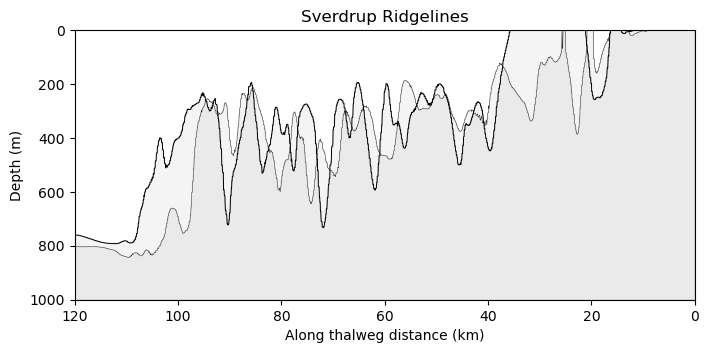

In [37]:
plt.rcParams["figure.figsize"] = (8,3.5)
max_depth=1000

plt.title("Sverdrup Ridgelines")
plt.fill_between(sverdrup_drawn_ridge_plus.distance/1000, sverdrup_drawn_ridge_plus.Bed_meters*-1, max_depth, color='dimgray', alpha=0.07)
plt.plot(sverdrup_drawn_ridge_plus.distance/1000, sverdrup_drawn_ridge_plus.Bed_meters*-1,'k',linewidth=0.3,zorder=1)
plt.fill_between(sverdrup_drawn_ridge_minus.distance/1000, sverdrup_drawn_ridge_minus.Bed_meters*-1, max_depth, color='dimgray', alpha=0.07)
plt.plot(sverdrup_drawn_ridge_minus.distance/1000, sverdrup_drawn_ridge_minus.Bed_meters*-1,'k',linewidth=0.7,zorder=1)
plt.xlabel("Along thalweg distance (km)")
plt.ylabel("Depth (m)")
plt.xlim(120,0)
plt.ylim(1000,0);

### 4b. Example CTD transect with ridgelines plotted

<img src="../Figures/Sverdrup_CTD_2020_temperature_transect.png" width=1000>